## UDSS Experiment on Toy Dataset 
### 1-Produce Synthetic Data
a score table with 2 NDs and 3 EDs, each entry is in [0, 100]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


np.random.seed(1234)
n_rows = 3000
n_cols = 5

In [2]:
avg_scale = [50, 60, 5, 1, 0.5]
std = [10, 5] # for the first two data sets
seed = 1234

def toy_data(n_rows):
    X = pd.DataFrame()
    X['0']=5*np.random.randn(n_rows) + avg_scale[0]
    X['1']=3*np.random.randn(n_rows)+ avg_scale[1]
    X['2'] = np.random.exponential(avg_scale[2], n_rows)
    X['3'] = np.random.exponential(avg_scale[3], n_rows)
    X['4'] = np.random.exponential(avg_scale[4], n_rows)
    return X

X=toy_data(n_rows)

           0          1          2         3         4
0  52.357176  59.523575   0.115547  4.049377  0.670793
1  44.045122  59.825844   0.186966  0.959883  0.671321
2  57.163535  57.215216  17.461241  0.384719  0.084638
3  48.436741  62.736985   1.136868  0.593388  2.253724
4  46.397056  61.615087   2.517185  0.070775  1.413299


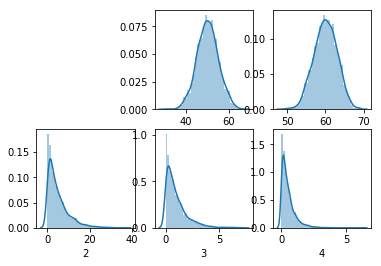

In [3]:
# EDA
print(X.head(5))

import seaborn as sns

# plt.subplot(231)
# sns.distplot(y)
plt.subplot(232)
sns.distplot(X['0'])
plt.subplot(233)
sns.distplot(X['1'])
plt.subplot(234)
sns.distplot(X['2'])
plt.subplot(235)
sns.distplot(X['3'])
plt.subplot(236)
sns.distplot(X['4'])
plt.show()

### 2-Construct performance matrix
use CDF to give individual score, 
%consider 2 NDs are already transformed to scores

In [4]:
import scipy.stats as st
import pandas as pd

P = pd.DataFrame()
# P['0'] = X['0']
# P['1'] = X['1']
for j in range(2):
    mu = avg_scale[j]
    sigma = std[j]
    P[str(j)] =  [st.norm.cdf(x, mu, sigma) * 100 for x in X[str(j)]]
for j in range(2, 5):
    mu = avg_scale[j]
    P[str(j)] =  [st.expon.cdf(x,scale=mu) * 100 for x in X[str(j)]]
print(P.head(5))

           0          1          2          3          4
0  59.317409  46.204420   2.284451  98.256677  73.856932
1  27.575871  48.610719   3.670270  61.706227  73.884505
2  76.311345  28.877847  96.956762  31.935832  15.572452
3  43.788805  70.794699  20.337688  44.754747  98.897343
4  35.931351  62.665900  39.555040   6.832834  94.078601


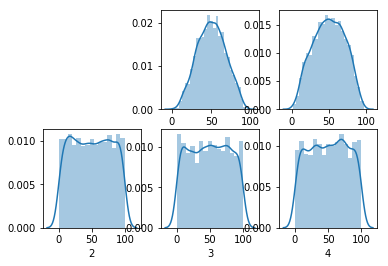

In [5]:
plt.subplot(232)
sns.distplot(P['0'])
plt.subplot(233)
sns.distplot(P['1'])
plt.subplot(234)
sns.distplot(P['2'])
plt.subplot(235)
sns.distplot(P['3'])
plt.subplot(236)
sns.distplot(P['4'])
plt.show()

### 3-Compute weight
use Entropy Weighted method

In [6]:
import math

def EW(x, n, maxval, minval):
    x = (x - minval)/(maxval - minval)
    s = np.sum(x)
    tmp = np.sum([e/s * math.log(e/s+ 1e-6) for e in x])
    print(tmp, math.log(n))
    p = - tmp / math.log(n)
#     print(p)
    d = 1 - p
#     print(d)
    return d

def scale(D):
    s = np.sum(D)
    D /= s
    return D

col_max = X.max(axis=0).values
col_min = X.min(axis=0).values

D = [EW(X[str(j)], n_rows, col_max[j], col_min[j]) for j in range(n_cols)]
w = scale(D)
print(w, np.sum(w))

-7.970488475727345 8.006367567650246
-7.962705531917015 8.006367567650246
-7.577947248573719 8.006367567650246
-7.57075712183544 8.006367567650246
-7.578280457104551 8.006367567650246
[0.02615744 0.03183155 0.31233734 0.31757926 0.31209441] 1.0


### 4-Output Validation
first fit the mean and std from y_hat, then compare the distribution of y_hat to the ground true N(mean, std) with
K-S test and Anderson-Darling test

Kolmogorov-Smirnov test performs a test of the distribution G(x) of an observed random variable against a given distribution F(x). Under the null hypothesis the two distributions are identical, G(x)=F(x). The alternative hypothesis can be either ‘two-sided’ (default), ‘less’ or ‘greater’. The KS test is only valid for continuous distributions.


The Anderson-Darling test is a modification of the Kolmogorov- Smirnov test kstest for the null hypothesis that a sample is drawn from a population that follows a particular distribution. For the Anderson-Darling test, the critical values depend on which distribution is being tested against. This function works for normal, exponential, logistic, or Gumbel (Extreme Value Type I) distributions.
Critical values provided are for the following significance levels:

normal/exponenential
15%, 10%, 5%, 2.5%, 1%
logistic
25%, 10%, 5%, 2.5%, 1%, 0.5%
Gumbel
25%, 10%, 5%, 2.5%, 1%

(50.09285602503491, 15.92171614386752)
SkewtestResult(statistic=0.4709506501761143, pvalue=0.6376759767416373)
KurtosistestResult(statistic=-3.920687071382225, pvalue=8.829686109961523e-05)


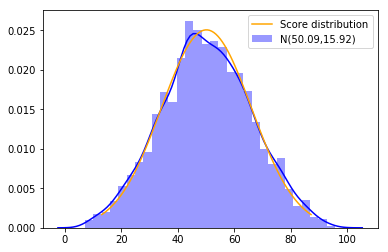

KstestResult(statistic=0.013488786553606358, pvalue=0.6460243555126054)
AndersonResult(statistic=0.6343228313871805, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [27]:
from scipy import stats
(u,std) = stats.norm.fit(y_hat)
print((u,std))
print(stats.skewtest(y_hat))
print(stats.kurtosistest(y_hat))
# plt.figure()
sns.distplot(y_hat, label='weighted sum score', color='b', kde=True)
normalDistribution = stats.norm(u, std)
x = np.linspace(normalDistribution.ppf(0.01), normalDistribution.ppf(0.99), 100)
plt.plot(x, normalDistribution.pdf(x), c='orange')
plt.legend(['Score distribution', 'N({:.2f},{:.2f})'.format(u, std)])
plt.show()


print(kstest(y_hat, 'norm', (u, std)))

print(anderson(y_hat, 'norm'))

the p-value is greater than the significance level (say 5%), then we cannot reject the hypothesis that the data come from the given distribution

### End of Test

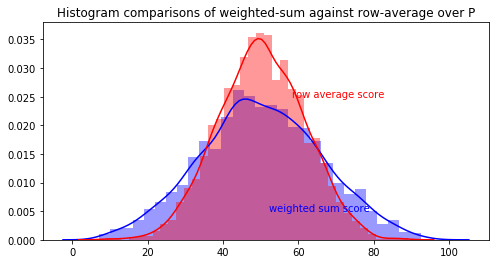

50.09285602503491 15.92171614386752
50.21684939891513 11.357833877416967


In [7]:
y = P.mean(axis=1)
y_hat = np.dot(P, w)

plt.figure(figsize=(8,4))#绘制画布
sns.distplot(y_hat, label='weighted sum score', color='b')
plt.text(np.mean(y_hat)+2,0.005,'weighted sum score', color = 'b')

sns.distplot(y, color='r', label='row average score')
plt.text(np.mean(y)+8,0.025,'row average score', color = 'r')

plt.title('Histogram comparisons of weighted-sum against row-average over P')
plt.show()
print(np.mean(y_hat), np.std(y_hat))
print(np.mean(y), np.std(y))

In [8]:
from scipy.stats import kstest, shapiro
from scipy.stats import normaltest
from scipy.stats import anderson

(u, std)=(np.mean(y_hat), np.std(y_hat))

In [21]:
print(shapiro(y_hat))

# print((u, std))
print(kstest(y_hat, 'norm', (u, std)))

print(normaltest(y_hat))

print(anderson(y_hat))

(0.9978645443916321, 0.00040872892714105546)
KstestResult(statistic=0.013488786553606358, pvalue=0.6460243555126054)
NormaltestResult(statistic=15.593581626605033, pvalue=0.00041105200718819933)
AndersonResult(statistic=0.6343228313871805, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [10]:
print(shapiro(X['1']))
print(normaltest(X['1']))

(0.9984280467033386, 0.005290188826620579)
NormaltestResult(statistic=10.009022165426643, pvalue=0.0067076200180437315)


In [11]:
test1 =  shapiro(y)
print(test1)

test1 = kstest(y, 'norm', (50, np.std(y)))
print(test1)

test1 = normaltest(y)
print(test1)

test1 = anderson(y)
print(test1)

(0.9995035529136658, 0.662087619304657)
KstestResult(statistic=0.014833575540532773, pvalue=0.5239960452853454)
NormaltestResult(statistic=1.6048944209857074, pvalue=0.4482307059440612)
AndersonResult(statistic=0.2969889216683441, critical_values=array([0.575, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
